In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Input, Dropout, LSTM, Activation, GlobalMaxPool1D, Flatten, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
np.random.seed(125)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def kaggle_text_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1BwYx3Mp60_hMSHlsNuNW9fVI2-XHlFrK'})
  fileDownloaded.GetContentFile('data1.csv')
  x_test = pd.read_csv('data1.csv')
  fileDownloaded = drive.CreateFile({'id':'19ddTDm2OvZA-Cdo1Mbji_SrZfOmVi-S1'})
  fileDownloaded.GetContentFile('data2.csv')
  x_train = pd.read_csv('data2.csv')
  fileDownloaded = drive.CreateFile({'id':'1iiE0whOEHDAUGo3-Sc2phR_vEj3_i8DG'})
  fileDownloaded.GetContentFile('data3.csv')
  x_valid = pd.read_csv('data3.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
def kaggle_label_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1fZMyxj--k93sRjn76AwzXvKrzT_l7yve'})
  fileDownloaded.GetContentFile('data4.csv')
  y_test = pd.read_csv('data4.csv')
  fileDownloaded = drive.CreateFile({'id':'1MFPvAsBxbrfnZKA9_mhuqy6Vy5Wj4jZb'})
  fileDownloaded.GetContentFile('data5.csv')
  y_train = pd.read_csv('data5.csv')
  fileDownloaded = drive.CreateFile({'id':'1py-_sIVo13sN2VfosZczZ_vBO5ZmbIJg'})
  fileDownloaded.GetContentFile('data6.csv')
  y_valid = pd.read_csv('data6.csv')

  print(y_test.shape)
  print(y_train.shape)
  print(y_valid.shape)

  return y_test, y_train, y_valid

In [ ]:
def get_vocab():
  fileDownloaded = drive.CreateFile({'id':'1FmCAmUgGYlGuJ3qgnuO5kS6EvMsbkzsb'})
  fileDownloaded.GetContentFile('vocab_text.txt')
  kaggle_vocab_text_size = int(np.loadtxt('vocab_text.txt'))

  fileDownloaded = drive.CreateFile({'id':'1e1D1m08LNKwqBDwIEv7jkvmp49QLKxCG'})
  fileDownloaded.GetContentFile('vocab_title.txt')
  kaggle_vocab_title_size = int(np.loadtxt('vocab_title.txt'))

  fileDownloaded = drive.CreateFile({'id':'1pvzUv4z8qbfic5uVnLSR8zjo77H8v-h8'})
  fileDownloaded.GetContentFile('liar_vocab_text.txt')
  liar_vocab_text_size = int(np.loadtxt('liar_vocab_text.txt'))

  return kaggle_vocab_text_size, kaggle_vocab_title_size, liar_vocab_text_size

In [ ]:
def model1(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Conv1D(input_shape=(x_train.shape[1],1),filters=64 ,kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPool1D())
  #model.add(Conv1D(input_shape=(1200,1),filters=128 ,kernel_size=5, padding='same', activation='relu'))
  #model.add(MaxPooling1D(5))
  #model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'],)
  print(model.summary())
  return model

In [ ]:
def fit_model(model, x_train, y_train, x_valid,y_valid, epo):
  history = model.fit(x_train, y_train.to_numpy(), epochs=epo, batch_size = 256, validation_data=(x_valid,y_valid.to_numpy()), verbose=1)
  return history

In [ ]:
def evaluate(model, x_test, y_test):
  loss, acc = model.evaluate(x_test.to_numpy().reshape(x_test.shape[0], x_test.shape[1]), y_test)
  print('Test Accuracy : {}\nLoss : {}'.format(acc,loss))

In [ ]:
def pred_confusion(model, x_test, y_test, classes):
  
  pred = model.predict(x_test.to_numpy().reshape(x_test.shape[0], x_test.shape[1]))
  if classes > 1:
    pred = np.argmax(pred, axis = 1)
    confusion = tf.math.confusion_matrix(y_test.to_numpy(), predictions=pred, num_classes=classes)
  else:
    pred = np.around(pred)
    confusion = confusion_matrix(y_test.to_numpy(), pred)
  print(pred)
  sns.heatmap(confusion, annot = True)
  plt.show()

  print(classification_report(y_test.to_numpy(), pred))

In [ ]:
def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
x_test, x_train, x_valid = kaggle_text_seq_data()

(3652, 1200)
(10942, 1200)
(3617, 1200)


In [ ]:
y_test, y_train, y_valid = kaggle_label_seq_data()

(3652, 1)
(10942, 1)
(3617, 1)


In [ ]:
vocab1, vocab2, vocab3 = get_vocab()

In [ ]:
modelv1 = model1(x_train.shape[1], 0.001, vocab1)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1200, 100)         19387400  
                                                                 
 conv1d_22 (Conv1D)          (None, 1200, 64)          19264     
                                                                 
 global_max_pooling1d_22 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_81 (Dense)            (None, 100)               6500      
                                                                 
 dense_82 (Dense)            (None, 1)                 101       
                                                                 
Total params: 19,413,265
Trainable params: 19,413,265
Non-trainable params: 0
_________________________________________

In [ ]:
history = fit_model(modelv1, x_train, y_train, x_valid,y_valid, 5)

Epoch 1/5
43/43 [==============================] - 59s 1s/step - loss: 0.5961 - accuracy: 0.6572 - val_loss: 0.3832 - val_accuracy: 0.9121
Epoch 2/5
43/43 [==============================] - 58s 1s/step - loss: 0.1701 - accuracy: 0.9538 - val_loss: 0.0820 - val_accuracy: 0.9724
Epoch 3/5
43/43 [==============================] - 60s 1s/step - loss: 0.0353 - accuracy: 0.9912 - val_loss: 0.0558 - val_accuracy: 0.9798
Epoch 4/5
43/43 [==============================] - 58s 1s/step - loss: 0.0095 - accuracy: 0.9993 - val_loss: 0.0510 - val_accuracy: 0.9806
Epoch 5/5
43/43 [==============================] - 57s 1s/step - loss: 0.0035 - accuracy: 0.9999 - val_loss: 0.0497 - val_accuracy: 0.9820


In [ ]:
evaluate(modelv1, x_test, y_test)

115/115 [==============================] - 5s 39ms/step - loss: 0.0472 - accuracy: 0.9808
Test Accuracy : 0.9808323979377747
Loss : 0.047242823988199234


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


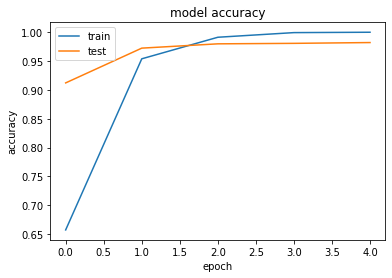

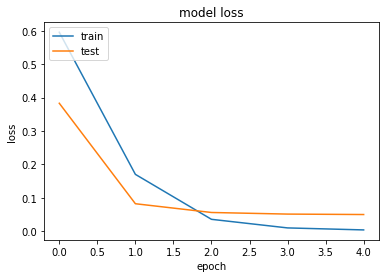

In [ ]:
print(history.history.keys())
plot_history(history)

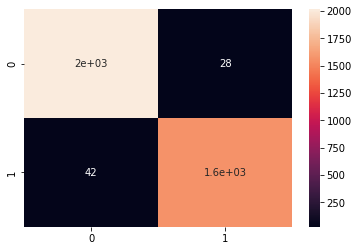

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2042
           1       0.98      0.97      0.98      1610

    accuracy                           0.98      3652
   macro avg       0.98      0.98      0.98      3652
weighted avg       0.98      0.98      0.98      3652



In [ ]:
pred_confusion(modelv1, x_test, y_test, 1)

In [ ]:
modelv1.save('v1.model')

INFO:tensorflow:Assets written to: v1.model/assets


In [ ]:
def model2(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(GlobalMaxPool1D())
  model.add(Dense(units = 100 , activation = 'relu' ,input_shape=(shape,1)))
  model.add(Dense(units = 50 , activation = 'relu'))
  model.add(Dense(units = 25 , activation = 'relu'))
  model.add(Dense(units = 10 , activation = 'relu'))
  model.add(Dense(units = 1 , activation = 'sigmoid'))
  model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
  print(model.summary())
  return model

In [ ]:
modelv2 = model2(x_train.shape[1], 0.001, vocab1)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 1200, 100)         19387400  
                                                                 
 global_max_pooling1d_39 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_164 (Dense)           (None, 100)               10100     
                                                                 
 dense_165 (Dense)           (None, 50)                5050      
                                                                 
 dense_166 (Dense)           (None, 25)                1275      
                                                                 
 dense_167 (Dense)           (None, 10)                260       
                                                     

In [ ]:
history = fit_model(modelv2, x_train, y_train, x_valid,y_valid, 5)

Epoch 1/5
43/43 [==============================] - 19s 437ms/step - loss: 0.6818 - accuracy: 0.5652 - val_loss: 0.6598 - val_accuracy: 0.5803
Epoch 2/5
43/43 [==============================] - 18s 430ms/step - loss: 0.5580 - accuracy: 0.6417 - val_loss: 0.3901 - val_accuracy: 0.8814
Epoch 3/5
43/43 [==============================] - 18s 429ms/step - loss: 0.2120 - accuracy: 0.9617 - val_loss: 0.1048 - val_accuracy: 0.9630
Epoch 4/5
43/43 [==============================] - 19s 437ms/step - loss: 0.0329 - accuracy: 0.9909 - val_loss: 0.0733 - val_accuracy: 0.9746
Epoch 5/5
43/43 [==============================] - 18s 430ms/step - loss: 0.0089 - accuracy: 0.9990 - val_loss: 0.0735 - val_accuracy: 0.9712


In [ ]:
evaluate(modelv2, x_test, y_test)

115/115 [==============================] - 1s 11ms/step - loss: 0.0807 - accuracy: 0.9732
Test Accuracy : 0.9731653928756714
Loss : 0.08072222024202347


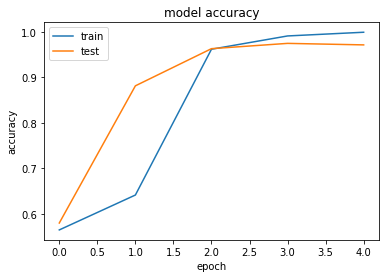

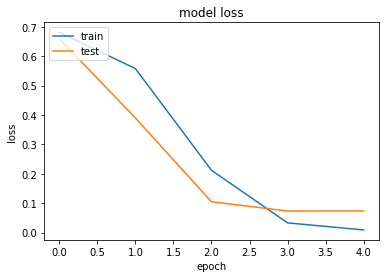

In [ ]:
plot_history(history)

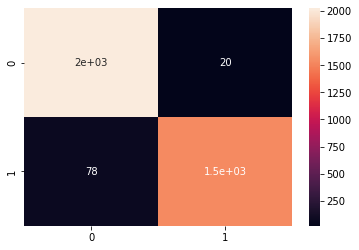

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2042
           1       0.99      0.95      0.97      1610

    accuracy                           0.97      3652
   macro avg       0.97      0.97      0.97      3652
weighted avg       0.97      0.97      0.97      3652



In [ ]:
pred_confusion(modelv2, x_test, y_test, 1)

In [ ]:
modelv2.save('v2.model')

INFO:tensorflow:Assets written to: v2.model/assets


In [ ]:
def kaggle_title_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1Ws0wRmdWzyrflqaMzktGMMQE6mx5aeEO'})
  fileDownloaded.GetContentFile('data7.csv')
  x_test = pd.read_csv('data7.csv')
  fileDownloaded = drive.CreateFile({'id':'1t1pArqIsRlNcOhcZaFWugTFfvl_-RBDP'})
  fileDownloaded.GetContentFile('data8.csv')
  x_train = pd.read_csv('data8.csv')
  fileDownloaded = drive.CreateFile({'id':'1H7x7-6IYPbSmMV7elq7U2qVwVHh0fwwO'})
  fileDownloaded.GetContentFile('data9.csv')
  x_valid = pd.read_csv('data9.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
x_test, x_train, x_valid = kaggle_title_seq_data()

(3652, 30)
(10942, 30)
(3617, 30)


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 30, 100)           2262500   
                                                                 
 conv1d_23 (Conv1D)          (None, 30, 64)            19264     
                                                                 
 global_max_pooling1d_30 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_128 (Dense)           (None, 100)               6500      
                                                                 
 dense_129 (Dense)           (None, 1)                 101       
                                                                 
Total params: 2,288,365
Trainable params: 2,288,365
Non-trainable params: 0
___________________________________________

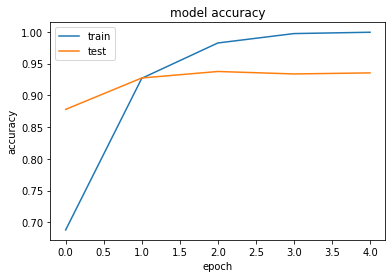

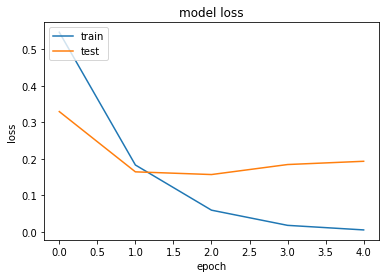

115/115 [==============================] - 1s 4ms/step - loss: 0.1856 - accuracy: 0.9378
Test Accuracy : 0.9378422498703003
Loss : 0.18555611371994019


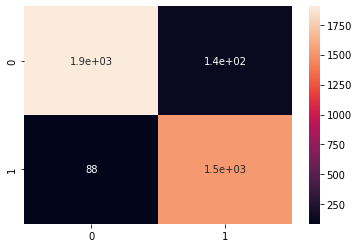

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2042
           1       0.92      0.95      0.93      1610

    accuracy                           0.94      3652
   macro avg       0.94      0.94      0.94      3652
weighted avg       0.94      0.94      0.94      3652



In [ ]:
modelv1 = model1(x_train.shape[1], 0.001, vocab2)
history = fit_model(modelv1, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv1, x_test, y_test)
pred_confusion(modelv1, x_test, y_test, 1)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 30, 100)           2262500   
                                                                 
 global_max_pooling1d_34 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_145 (Dense)           (None, 100)               10100     
                                                                 
 dense_146 (Dense)           (None, 50)                5050      
                                                                 
 dense_147 (Dense)           (None, 25)                1275      
                                                                 
 dense_148 (Dense)           (None, 10)                260       
                                                     

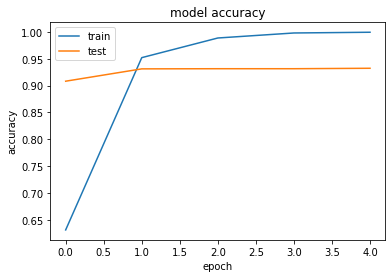

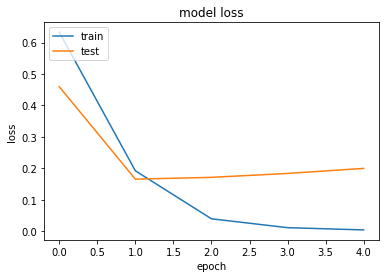

115/115 [==============================] - 0s 2ms/step - loss: 0.2044 - accuracy: 0.9310
Test Accuracy : 0.9309967160224915
Loss : 0.20435096323490143


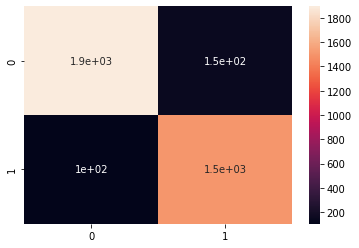

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2042
           1       0.91      0.94      0.92      1610

    accuracy                           0.93      3652
   macro avg       0.93      0.93      0.93      3652
weighted avg       0.93      0.93      0.93      3652



In [ ]:
modelv2 = model2(x_train.shape[1], 0.001, vocab2)
history = fit_model(modelv2, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv2, x_test, y_test)
pred_confusion(modelv2, x_test, y_test, 1)

In [ ]:
def liar_word_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1hgBqRUoxN5zZm7ULQS70MUr8CWWvy6ka'})
  fileDownloaded.GetContentFile('data10.csv')
  x_test = pd.read_csv('data10.csv')
  fileDownloaded = drive.CreateFile({'id':'17odMtLAuFDTYgpaqQX1HrWPa8gkXUZVF'})
  fileDownloaded.GetContentFile('data11.csv')
  x_train = pd.read_csv('data11.csv')
  fileDownloaded = drive.CreateFile({'id':'1a3PospnIizV2unk9lmQEjR5WL0uGO0b5'})
  fileDownloaded.GetContentFile('data12.csv')
  x_valid = pd.read_csv('data12.csv')

  print(x_test.shape)
  print(x_train.shape)
  print(x_valid.shape)

  return x_test, x_train, x_valid

In [ ]:
def liar_label_seq_data():
  fileDownloaded = drive.CreateFile({'id':'1SkKStY75b9iLsEiXFCXNNEAIP8jMMUMn'})
  fileDownloaded.GetContentFile('data13.csv')
  y_test = pd.read_csv('data13.csv')
  fileDownloaded = drive.CreateFile({'id':'1EdQ8C2nzEB0DuwyXO9gqTz0Z2K7qVBtq'})
  fileDownloaded.GetContentFile('data14.csv')
  y_train = pd.read_csv('data14.csv')
  fileDownloaded = drive.CreateFile({'id':'1sKOCruFD4Pv-lmOjjnl8cSqHDjPxRaSj'})
  fileDownloaded.GetContentFile('data15.csv')
  y_valid = pd.read_csv('data15.csv')

  print(y_test.shape)
  print(y_train.shape)
  print(y_valid.shape)

  return y_test, y_train, y_valid

In [ ]:
x_test, x_train, x_valid = liar_word_seq_data()
y_test, y_train, y_valid = liar_label_seq_data()

(1167, 50)
(9465, 50)
(1183, 50)
(1167, 1)
(9465, 1)
(1183, 1)


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 conv1d_29 (Conv1D)          (None, 50, 64)            19264     
                                                                 
 global_max_pooling1d_43 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_175 (Dense)           (None, 100)               6500      
                                                                 
 dense_176 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,521,565
Trainable params: 1,521,565
Non-trainable params: 0
___________________________________________

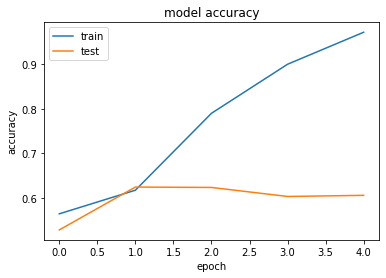

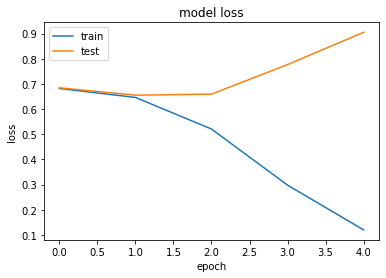

37/37 [==============================] - 0s 4ms/step - loss: 0.9420 - accuracy: 0.5964
Test Accuracy : 0.596401035785675
Loss : 0.941976010799408


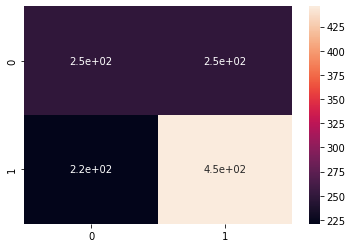

              precision    recall  f1-score   support

           0       0.53      0.50      0.51       500
           1       0.64      0.67      0.65       667

    accuracy                           0.60      1167
   macro avg       0.59      0.58      0.58      1167
weighted avg       0.59      0.60      0.59      1167

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 global_max_pooling1d_44 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_177 (Dense)           (None, 100)               10100     
                                                                 
 dense_178 (Dense)           (None, 50)                5

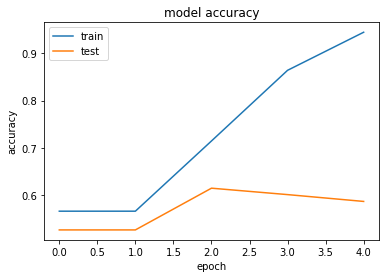

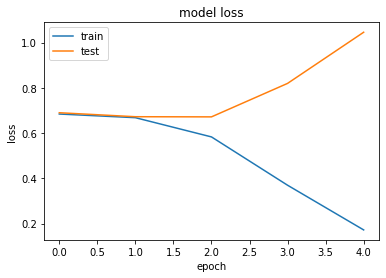

37/37 [==============================] - 0s 3ms/step - loss: 1.0315 - accuracy: 0.5818
Test Accuracy : 0.5818337798118591
Loss : 1.0314898490905762


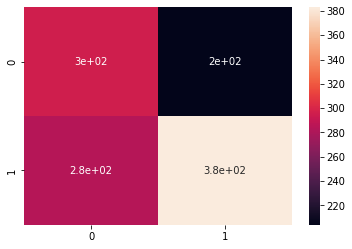

              precision    recall  f1-score   support

           0       0.51      0.59      0.55       500
           1       0.65      0.57      0.61       667

    accuracy                           0.58      1167
   macro avg       0.58      0.58      0.58      1167
weighted avg       0.59      0.58      0.58      1167



In [ ]:
y_test = y_test.mask(y_test < 0, 0)
y_test = y_test.mask(y_test > 0, 1)

y_train = y_train.mask(y_train < 0, 0)
y_train = y_train.mask(y_train > 0, 1)
                     
y_valid = y_valid.mask(y_valid < 0, 0)
y_valid = y_valid.mask(y_valid > 0, 1)

modelv11 = model1(x_train.shape[1], 0.001, vocab3)
history = fit_model(modelv11, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv11, x_test, y_test)
pred_confusion(modelv11, x_test, y_test, 1)

modelv22 = model2(x_train.shape[1], 0.001, vocab3)
history = fit_model(modelv22, x_train, y_train, x_valid,y_valid, 5)
plot_history(history)
evaluate(modelv22, x_test, y_test)
pred_confusion(modelv22, x_test, y_test, 1)

In [ ]:
def model3(shape, lr, vocab_text_size):
  opt = tf.keras.optimizers.Adam(learning_rate= lr)
  model = Sequential()
  #model.add(Embedding(input_dim=vocab_text_size, input_length=x_train.shape[1], output_dim=100))
  model.add(Conv1D(input_shape=(shape,1),filters=64 ,kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPool1D())
  #modelv1.add(Conv1D(input_shape=(1200,1),filters=128 ,kernel_size=5, padding='same', activation='relu'))
  #modelv1.add(MaxPooling1D(5))
  #model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
  print(model.summary())
  return model


In [ ]:
x_test, x_train, x_valid = liar_word_seq_data()
y_test, y_train, y_valid = liar_label_seq_data()

(1167, 50)
(9465, 50)
(1183, 50)
(1167, 1)
(9465, 1)
(1183, 1)


In [ ]:
for i in range(y_test.shape[0]):
  if y_test.loc[i].label < 0:
    y_test.loc[i].label = y_test.loc[i].label + 3
  else:
     y_test.loc[i].label = y_test.loc[i].label + 2

for i in range(y_train.shape[0]):
  if y_train.loc[i].label < 0:
    y_train.loc[i].label = y_train.loc[i].label + 3
  else:
     y_train.loc[i].label = y_train.loc[i].label + 2

for i in range(y_valid.shape[0]):
  if y_valid.loc[i].label < 0:
    y_valid.loc[i].label = y_valid.loc[i].label + 3
  else:
     y_valid.loc[i].label = y_valid.loc[i].label + 2


Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 50, 64)            256       
                                                                 
 global_max_pooling1d_70 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_312 (Dense)           (None, 100)               6500      
                                                                 
 dense_313 (Dense)           (None, 6)                 606       
                                                                 
Total params: 7,362
Trainable params: 7,362
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
37/37 [==============================] - 1s 20ms/step - loss: 2582.3816 - accuracy: 0.1643 - val_loss

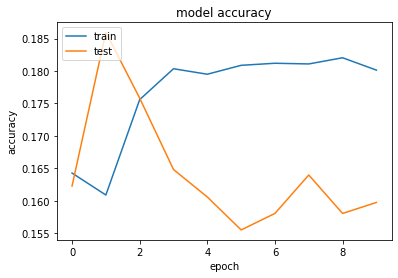

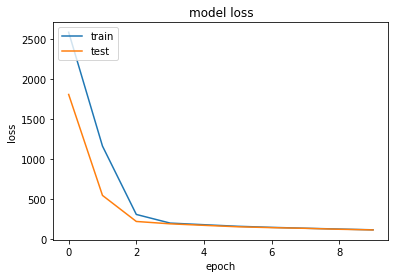

37/37 [==============================] - 0s 2ms/step - loss: 116.1266 - accuracy: 0.1834
Test Accuracy : 0.18337617814540863
Loss : 116.12663269042969
[4 1 1 ... 3 5 2]


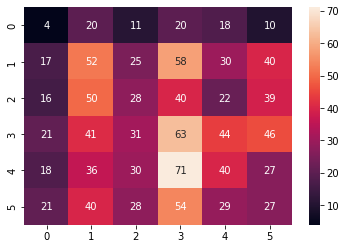

              precision    recall  f1-score   support

           0       0.04      0.05      0.04        83
           1       0.22      0.23      0.23       222
           2       0.18      0.14      0.16       195
           3       0.21      0.26      0.23       246
           4       0.22      0.18      0.20       222
           5       0.14      0.14      0.14       199

    accuracy                           0.18      1167
   macro avg       0.17      0.17      0.17      1167
weighted avg       0.18      0.18      0.18      1167



In [ ]:
modelv3 = model3(x_train.shape[1], 0.0001, vocab3)
history = fit_model(modelv3, x_train, y_train, x_valid,y_valid, 10)
plot_history(history)
evaluate(modelv3, x_test, y_test)
pred_confusion(modelv3, x_test, y_test, 6)

In [ ]:
def model4(shape, lr, vocab_size):
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=x_train.shape[1], output_dim=100))
  model.add(GlobalMaxPool1D())
  model.add(Dense(units = 100 , activation = 'relu' ,input_shape=(shape,1)))
  model.add(Dense(units = 50 , activation = 'relu'))
  model.add(Dense(units = 25 , activation = 'relu'))
  model.add(Dense(units = 10 , activation = 'relu'))
  model.add(Dense(units = 6 , activation = 'softmax'))
  model.compile(optimizer = opt , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  print(model.summary())
  return model

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 50, 100)           1495700   
                                                                 
 global_max_pooling1d_71 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_314 (Dense)           (None, 100)               10100     
                                                                 
 dense_315 (Dense)           (None, 50)                5050      
                                                                 
 dense_316 (Dense)           (None, 25)                1275      
                                                                 
 dense_317 (Dense)           (None, 10)                260       
                                                     

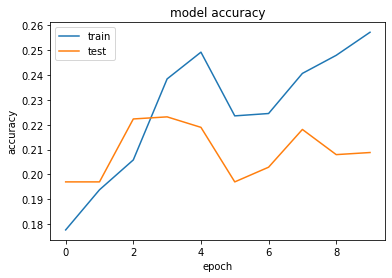

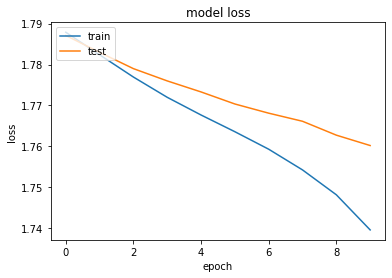

37/37 [==============================] - 0s 2ms/step - loss: 1.7489 - accuracy: 0.2434
Test Accuracy : 0.2433590441942215
Loss : 1.7488905191421509
[3 3 3 ... 3 3 3]


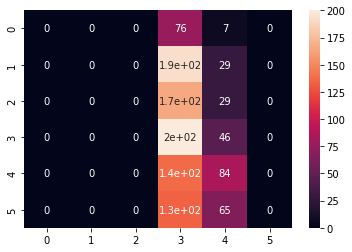

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.00      0.00      0.00       222
           2       0.00      0.00      0.00       195
           3       0.22      0.81      0.35       246
           4       0.32      0.38      0.35       222
           5       0.00      0.00      0.00       199

    accuracy                           0.24      1167
   macro avg       0.09      0.20      0.12      1167
weighted avg       0.11      0.24      0.14      1167



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
modelv4 = model4(x_train.shape[1], 0.0001, vocab3)
history = fit_model(modelv4, x_train, y_train, x_valid,y_valid, 10)
plot_history(history)
evaluate(modelv4, x_test, y_test)
pred_confusion(modelv4, x_test, y_test, 6)